<a href="https://colab.research.google.com/github/kg-for-product-design/kg-for-product-design.github.io/blob/main/program/knowledge_graph_for_product_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph for Product Design

Smart product dataset: https://kg-for-product-design.github.io/dataset/knowledge.csv

Prediction test set: https://kg-for-product-design.github.io/dataset/prediction_test.csv

The dataset can be adapted and put into [Neo4j visualization tools](https://neo4j.com/developer/tools-graph-visualization/) for more interactive and detailed observation.

A basic knowledge graph visualization based on [AntV G6](https://g6.antv.vision/): https://kg-for-product-design.github.io/

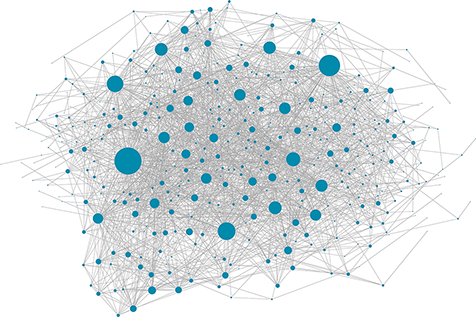

The node size in the knowledge graph visualization is based on the number of edges, and the largest node is "smart phone", which has over one hundred edges.


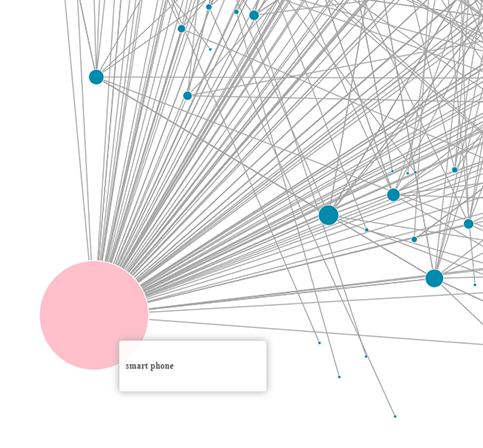

## Load dependencies

The primary library used here is [AmpliGraph](https://docs.ampligraph.org/). This repository is adapted from official example snippets and only for demonstration of the link prediction. Several steps which are not the main focus of this repository, such as the evaluation of model, are skipped. The full examples can be found in the documentation of the library.

In [ ]:
%%capture
!pip install ampligraph;
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import ampligraph

## Import dataset

In [ ]:
import requests
from ampligraph.datasets import load_from_csv

url = 'https://kg-for-product-design.github.io/dataset/knowledge.csv'
open('data.csv', 'wb').write(requests.get(url).content)
knowledge_data = load_from_csv('.', 'data.csv', sep=',')

The dataset contains 550 entities connected with 3155 relations of 8 types.

In [ ]:
entities = np.unique(np.concatenate([knowledge_data[:, 0], knowledge_data[:, 2]]))
print("number of entities:", len(entities))
relations = knowledge_data[:, 1]
print("number of relations:", len(relations))
type_of_relations = np.unique(knowledge_data[:, 1])
print("number of relation types:", len(type_of_relations))

number of entities: 550
number of relations: 3155
number of relation types: 8


AmpliGraph offers a range of models, and the model used here is ComplEx

In [ ]:
from ampligraph.latent_features import ComplEx
model = ComplEx(batches_count=128, 
                seed=0, 
                epochs=500, 
                k=150,
                eta=10,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

The model defined is trained with dataset.

In [ ]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(knowledge_data, early_stopping = False)

Average ComplEx Loss:   0.107217: 100%|██████████| 500/500 [07:38<00:00,  1.09epoch/s]


After the training, we can use this model for prediction of links between entities.

In [ ]:
import requests
from ampligraph.datasets import load_from_csv

url = 'https://kg-for-product-design.github.io/dataset/prediction_test.csv'
open('data.csv', 'wb').write(requests.get(url).content)
test_set = load_from_csv('.', 'data.csv', sep=',')
tests_with_values = np.array(test_set)
tests = tests_with_values[1:, [0, 1, 2]]
scores = model.predict(tests)

The prediction results here have not go through a process of calibration, which involves additional data labeling different from the training dataset. Instead, normalization is applied on the results. In this way, the normalized probabilities are not directly reflecting the predicted absolute values, but the relative probabilities among relations are valid. Same applies to the values of `correctness`.

In [ ]:
def normalize(s):
   return (s - np. min(s)) / (np. max(s) - np. min(s))
probs = normalize(scores)
predicted = list(map(lambda p : str(p >= 0.5).upper(), probs))
correctness = list(map(lambda a, b : a == b, predicted, np.squeeze(tests_with_values[1:, 3])))

Then list the results

In [ ]:
pd.set_option('display.max_rows', len(scores))
pd.DataFrame(list(zip([' '.join(x) for x in tests],
                      np.squeeze(scores),
                      np.squeeze(probs),
                      predicted,
                      np.squeeze(tests_with_values[1:, 3]),
                      correctness
                    )),
             columns=['statement', 
                      'score',
                      'probability(relative)',
                      'predicted value', 
                      'actual value',
                      'correctness'
                      ])

,statement,score,probability(relative),predicted value,actual value,correctness
0,kindle functionally coupled with smart air con...,8.606997,0.884704,TRUE,FALSE,False
1,smart air purifier functionally coupled with s...,-6.421433,0.101139,FALSE,FALSE,True
2,smart air conditioner functionally coupled wit...,-3.968899,0.229011,FALSE,FALSE,True
3,air quality sensor functionally coupled with s...,3.657186,0.626626,TRUE,FALSE,False
4,smart scale functionally coupled with smart sp...,-4.829440,0.184143,FALSE,FALSE,True
5,smart scale functionally coupled with air qual...,-7.477757,0.046063,FALSE,FALSE,True
6,smart scale functionally coupled with smart le...,-5.854017,0.130723,FALSE,FALSE,True
7,smart led bulb functionally coupled with usb c...,2.869120,0.585537,TRUE,FALSE,False
8,smart toothbrush functionally coupled with sma...,-2.484372,0.306412,FALSE,FALSE,True
9,smart toothbrush functionally coupled with leg...,-8.361225,0.000000,FALSE,FALSE,True


In [ ]:
print("accuracy: ", sum(map(lambda x : x, correctness)), "/", len(correctness))

accuracy:  75 / 100


From the result shown, under current settings, it can correctly predict 75 out of 100 items in the test set.

## Further information
Embeddings of entities can be clustered and classified, and an official example is given in https://docs.ampligraph.org/en/latest/generated/ampligraph.discovery.find_clusters.html . To do this, additional labeling of the dataset may be required.